In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import dtreeviz

# Predicting who passes the final

To demonstrate the learning algorithm of gradient boosting on trees, we will use a simple dataset that predicts who passes the final exam based on a few recorded features. The dataset is shown below.

| Studied | Completed Assignments | Grade | Passed Final |
| ------- | --------------------- | ----- | ------------ |
| 1       | 5                     | 0     | 1            |
| 1       | 4                     | 0     | 1            |
| 0       | 5                     | 1     | 1            |
| 1       | 3                     | 2     | 1            |
| 0       | 4                     | 1     | 0            |
| 1       | 2                     | 2     | 0            |

The grade number corresponds to the letter grade, where A = 0, B = 1, and C = 2.

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def log_odds(x):
    return np.log((x==1).sum() / (x==0).sum())

def compute_residual(target, prob):
    return target - prob

def compute_leaf_output(model, data, residuals, probs):
    """Computes the gamma values for each leaf node in a weak learner."""
    leaf_idxs = model.apply(data) - 1
    num_leaves = model.get_n_leaves()
    gamma_n = np.zeros(num_leaves)
    gamma_d = np.zeros(num_leaves)
    if np.isscalar(probs):
        p = np.ones_like(residuals) * probs
    else:
        p = probs
    for i in range(num_leaves):
        sample_idxs = (leaf_idxs == i)
        gamma_n[i] = np.sum(residuals[sample_idxs])
        gamma_d[i] = np.sum(p[sample_idxs] * (1 - p[sample_idxs]))

    gamma = gamma_n / gamma_d

    return gamma



f0 = 0.6931471805599453
p0 = 0.6666666666666666
r0 = [ 0.33333333  0.33333333  0.33333333  0.33333333 -0.66666667 -0.66666667]


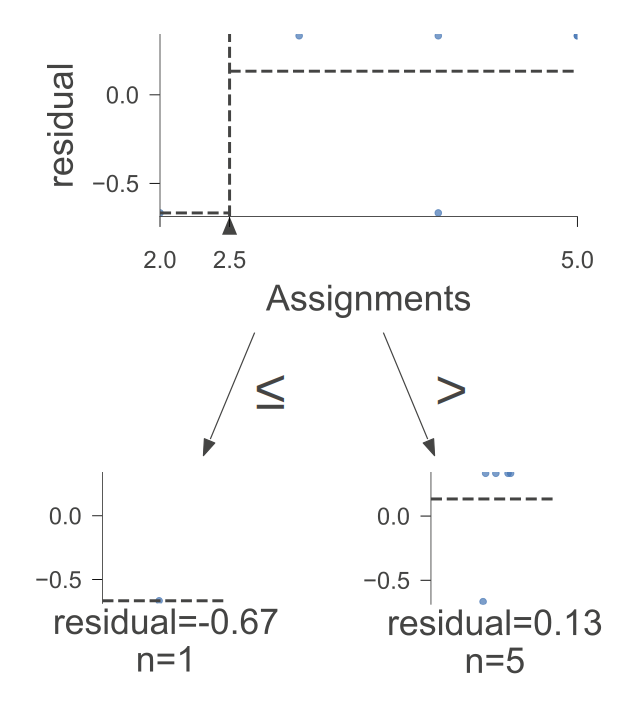

In [3]:
X = np.array([
    [1, 5, 0],
    [1, 4, 0],
    [0, 5, 1],
    [1, 3, 2],
    [0, 4, 1],
    [1, 2, 2]
])
y = np.array([1, 1, 1, 1, 0, 0])
feature_names = ["Studied", "Assignments", "Grade"]

# 1. Create base classifier -- the log odds of the data
f0 = log_odds(y)
print(f"f0 = {f0}")

# 2. Create new weak learner by first converting original learner output into probabilities
p0 = sigmoid(f0)
print(f"p0 = {p0}")

# 2a. Compute residuals of the initial learner to use as targets to fit the new learner
r0 = compute_residual(y, p0)
print(f"r0 = {r0}")

# 2b. Fit a new learner using residuals
f1 = DecisionTreeRegressor(max_depth=1).fit(X, r0)

tree_vis = dtreeviz.model(f1, X, r0, feature_names=feature_names, target_name="residual")
tree_vis.view(scale=4.0)

Now that the weak learner is fit to the residuals, each leaf node is optimized to minimize the logistic loss function.

\begin{align*}
\gamma_{jm} &= \text{arg min}_y \sum_{x_i \in R_{jm}}L(y_i, F_{m-1}(x_i) + \gamma)\\
&= \log(1 + \exp(\hat{y}_i + \gamma)) - y_i(\hat{y}_i + \gamma)
\end{align*}

This does not have a closed form solution but can be approximated via [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method).

$$
\gamma_{jm} = \frac{\sum_i y_i - p_i}{\sum_i p_i(1 - p_i)}
$$

In [4]:
f1_out = compute_leaf_output(f1, X, r0, p0)

# Compute the boosted classifier F1 by combining the f0 and f1
eta = 0.5
leaf_idxs = f1.apply(X) - 1
print(leaf_idxs)
f1_preds = f0 + eta * f1_out[leaf_idxs]
print(f"f1 predictions: {f1_preds}")

p1 = sigmoid(f1_preds)
print(f"f1 probabilities: {p1}")  # Note that these are higher for positive classes

r1 = compute_residual(y, p1)
print(f"f1 residuals: {r1}")  # These are also smaller

# Final classification for f1
y_pred = np.round(p1)
print(f"f1 final predictions: {y_pred}")

[1 1 1 1 1 0]
f1 predictions: [ 0.99314718  0.99314718  0.99314718  0.99314718  0.99314718 -0.80685282]
f1 probabilities: [0.7297091  0.7297091  0.7297091  0.7297091  0.7297091  0.30856155]
f1 residuals: [ 0.2702909   0.2702909   0.2702909   0.2702909  -0.7297091  -0.30856155]
f1 final predictions: [1. 1. 1. 1. 1. 0.]


In [5]:
# Round 2
f2 = DecisionTreeRegressor(max_depth=1).fit(X, r1)
f2_out = compute_leaf_output(f2, X, r1, p1)
leaf_idxs = f2.apply(X) - 1
f2_preds = f1_preds + eta * f2_out[leaf_idxs]
p2 = sigmoid(f2_preds)
r2 = compute_residual(y, p2)
y_pred = np.round(p2)

print(f"f2 predictions: {f2_preds}")
print(f"f2 probabilities: {p2}")
print(f"f2 residuals: {r2}")
print(f"f2 final predictions: {y_pred}")

f2 predictions: [ 1.67835174  0.68404383  1.67835174  0.68404383  0.68404383 -1.11595617]
f2 probabilities: [0.84268615 0.66464064 0.84268615 0.66464064 0.66464064 0.24676214]
f2 residuals: [ 0.15731385  0.33535936  0.15731385  0.33535936 -0.66464064 -0.24676214]
f2 final predictions: [1. 1. 1. 1. 1. 0.]


In [6]:
# Round 3
f3 = DecisionTreeRegressor(max_depth=1).fit(X, r2)
f3_out = compute_leaf_output(f3, X, r2, p2)
leaf_idxs = f3.apply(X) - 1
f3_preds = f2_preds + eta * f3_out[leaf_idxs]
p3 = sigmoid(f3_preds)
r3 = compute_residual(y, p3)
y_pred = np.round(p3)

print(f"f3 predictions: {f3_preds}")
print(f"f3 probabilities: {p3}")
print(f"f3 residuals: {r3}")
print(f"f3 final predictions: {y_pred}")

f3 predictions: [ 2.05865296  1.06434506  0.96473097  1.06434506 -0.02957693 -0.73565494]
f3 probabilities: [0.88681904 0.74352002 0.72406802 0.74352002 0.49260631 0.32395502]
f3 residuals: [ 0.11318096  0.25647998  0.27593198  0.25647998 -0.49260631 -0.32395502]
f3 final predictions: [1. 1. 1. 1. 0. 0.]
